In [99]:
#Setting the working directory to the project folder, easily access Git
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Raw"


C:\Users\siand\Downloads\Exeter\BEE2041 Data Science\Empirical Project\misogyny-in-lyrics\data\Raw


In [ ]:
#Skip executing cells shortcut as don't want to repeat webscrape
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return


In [ ]:
#Import pandas for data manipulation and loading dataset
import pandas as pd

df_rawdata = pd.read_csv("Full_Billboard_year_end_hot_100_USA.csv", encoding='latin1')
print(len(df_rawdata))

6789


In [102]:
#Filtering relevant 50 years + top 50 of each year using raw data into a filtered df
df_filtered = df_rawdata[(df_rawdata['Year'] >= 1972) & (df_rawdata['Year'] <= 2021)].copy()

#Extracting numeric ranking from No. column due to formatting, convert to int
df_filtered['No.'] = df_filtered['No.'].astype(str).str.extract(r'(\d+)')
df_filtered['No.'] = df_filtered['No.'].astype(int)
df_filtered = df_filtered[df_filtered['No.'] <= 50]

df_filtered #Clarify row numbers and view dataset

,No.,Title,Artist(s),Year
1789,1,The First Time Ever I Saw Your Face,Roberta Flack,1972
1790,2,Alone Again (Naturally),Gilbert O'Sullivan,1972
1791,3,American Pie,Don McLean,1972
1792,4,Without You,Harry Nilsson,1972
1793,5,The Candy Man,Sammy Davis Jr.,1972
...,...,...,...,...
6734,46,Need to Know,Doja Cat,2021
6735,47,Wants and Needs,Drake featuring Lil Baby,2021
6736,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021
6737,49,Telepatí­a,Kali Uchis,2021


In [103]:
import lyricsgenius #Import to access Genius Lyrics API
import time

#Using Genius Access Token to set up the API client
genius = lyricsgenius.Genius("FUkh9geZ4oUUMJkC2tTdDRl8PMjI-BCocha0AnShIdv-owl6OxhkhrQj9xijAK_F", 
                             skip_non_songs=True,
)


In [104]:
#Defining the function using Genius API to get lyrics
#In hindsight, the 'none' didn't work and we didn't automatically save it to a csv etc, took over 1000 minutes
def get_lyrics(title, artist):
    try:
        song = genius.search_song(title, artist)
        return song.lyrics if song else None
    except Exception as e:
        print(f"Error fetching '{title}' by {artist}: {e}")
        return None


In [105]:
%%skip
#Scrape the lyrics, showing progress, pause to avoid the API rate limits
lyrics = []

for i, row in df_rawdata.iterrows():
    title = row['Title']
    artist = row['Artist(s)']
    
    print(f"Fetching lyrics for: {title} by {artist}...")
    lyric = get_lyrics(title, artist)
    lyrics.append(lyric)
    
    time.sleep(1) 

In [ ]:
#Loading the lyrics from the json file to a list as we are not running the webscrape again to get the lyrics, surely there's another method?
import json
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Processed"
# Load the dataset with lyrics already saved
df_json = pd.read_json("lyrics_1972_2021.json")
# Rebuild the lyrics list
lyrics = df_json["Lyrics"].tolist()

C:\Users\siand\Downloads\Exeter\BEE2041 Data Science\Empirical Project\misogyny-in-lyrics\data\Processed


In [ ]:
#Adding the lyrics list as a column called "Lyrics" to a copy of the empty filtered df
df_withlyrics = df_filtered.copy()
df_withlyrics["Lyrics"] = lyrics

df_withlyrics.to_csv("lyrics_1972_2021.csv", index=False)
df_withlyrics.to_json("lyrics_1972_2021.json", orient="records", force_ascii=False, indent=2)

In [ ]:
#Songs containing no lyrics - something is wrong after inspection
df_json.tail(250) #read the json filelyrics_1972_2021.json and confirms missing last 5 years

,No.,Title,Artist(s),Year,Lyrics
2250,1,Shape of You,Ed Sheeran,2017,None
2251,2,Despacito (Remix),Luis Fonsi and Daddy Yankee featuring Justin B...,2017,None
2252,3,That's What I Like,Bruno Mars,2017,None
2253,4,Humble,Kendrick Lamar,2017,None
2254,5,Something Just Like This,The Chainsmokers and Coldplay,2017,None
...,...,...,...,...,...
2495,46,Need to Know,Doja Cat,2021,None
2496,47,Wants and Needs,Drake featuring Lil Baby,2021,None
2497,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021,None
2498,49,Telepatí­a,Kali Uchis,2021,None


In [ ]:
#After realising years 2017-2021 were missing, reran a webscrape for this specific time frame (later realise it's because there were 250 
#previous missing songs and instead of 'None' being placed where there were no lyrics, it was filled in with the next songs lyrics, 250 times)
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Raw"

#Set up the Genius API client
genius = lyricsgenius.Genius("9ai6TZ9Im0CTUKQp0mP13oC0fbgVlYiUlqoHhtn00cmecDo98cJ8hzVpdsd2rAku", 
                             skip_non_songs=True,
                             timeout=15)

#Filter from 2017–2021
df_missing = (
    df_filtered[(df_filtered["Year"] >= 2017) & (df_filtered["Year"] <= 2021)]
    .groupby("Year", group_keys=False)
    .apply(lambda x: x.nsmallest(50, columns="No."))
    .reset_index(drop=True)
)

#Define scraping function
def get_lyrics(title, artist):
    try:
        song = genius.search_song(title, artist)
        return song.lyrics if song else None
    except Exception as e:
        print(f"Error fetching '{title}' by {artist}: {e}")
        return None


C:\Users\siand\Downloads\Exeter\BEE2041 Data Science\Empirical Project\misogyny-in-lyrics\data\Raw


In [ ]:
%%skip
#Scrape for 2017-2021
lyrics2 = []

for i, row in df_missing.iterrows():
    title = row["Title"]
    artist = row["Artist(s)"]
    print(f"Fetching lyrics for: {title} by {artist}...")
    
    lyric = get_lyrics(title, artist)
    lyrics2.append(lyric)
    
    time.sleep(1) 

# Add lyrics back to dataframe
df_missing["Lyrics"] = lyrics2

# Save for merging later
df_missing.to_json("lyrics_2017_2021.json", orient="records", lines=False) #saved to the original file = caused a lot of problems + duplicates. 


In [ ]:
#Loading the lyrics from the json file to a list as we are not running the webscrape again 
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Processed"
#Load the dataset with lyrics already saved
df_json2 = pd.read_json("lyrics_2017_2021.json")
#Rebuild the lyrics list
lyrics2 = df_json2["Lyrics"].tolist()

C:\Users\siand\Downloads\Exeter\BEE2041 Data Science\Empirical Project\misogyny-in-lyrics\data\Processed


In [112]:
df_missing["Lyrics"] = lyrics2

In [ ]:
#Save to JSON and CSV - this was stupid, why use the same name?
df_missing.to_json("lyrics_2017_2021.json", orient="records", lines=False)
df_missing.to_csv("lyrics_2017_2021.csv", index=False)


In [114]:
# Load the original full dataset from the first webscrape (1972–2016)
df_withlyrics = pd.read_json("lyrics_1972_2021.json")

In [115]:
#Merge the first and second web scrape to try and get all years
#Remove 2017–2021 rows from df_withlyrics
df_withlyrics_clean = df_withlyrics[~df_withlyrics["Year"].isin([2017, 2018, 2019, 2020, 2021])]

#Combine with the updated entries 
df_full = pd.concat([df_withlyrics_clean, df_missing], ignore_index=True)

#Sort by Year and Ranking 
df_full.sort_values(by=["Year", "No."], inplace=True)
df_full.reset_index(drop=True, inplace=True)

df_full.to_json("lyrics_2017_2021_full.json", orient="records", lines=False)
df_full



,No.,Title,Artist(s),Year,Lyrics
0,1,The First Time Ever I Saw Your Face,Roberta Flack,1972,16 ContributorsThe First Time Ever I Saw Your ...
1,2,Alone Again (Naturally),Gilbert O'Sullivan,1972,50 ContributorsAlone Again (Naturally) Lyrics[...
2,3,American Pie,Don McLean,1972,262 ContributorsTranslationsPolskiAmerican Pie...
3,4,Without You,Harry Nilsson,1972,32 ContributorsWithout You Lyrics[Verse 1]\nNo...
4,5,The Candy Man,Sammy Davis Jr.,1972,15 ContributorsThe Candy Man Lyrics[Intro]\n(C...
...,...,...,...,...,...
2495,46,Need to Know,Doja Cat,2021,169 ContributorsTranslationsTürkçeEspañolРусск...
2496,47,Wants and Needs,Drake featuring Lil Baby,2021,267 ContributorsTranslationsTürkçeРусскийPortu...
2497,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021,2 ContributorsTranslationsEnglishTürkçeEspañol...
2498,49,Telepatí­a,Kali Uchis,2021,None


In [116]:
#after inspection of what I though was a full df, I noticed the lyrics were wrong at 22 and consequently everything shifted afterwards

df_full.head(30)

,No.,Title,Artist(s),Year,Lyrics
0,1,The First Time Ever I Saw Your Face,Roberta Flack,1972,16 ContributorsThe First Time Ever I Saw Your ...
1,2,Alone Again (Naturally),Gilbert O'Sullivan,1972,50 ContributorsAlone Again (Naturally) Lyrics[...
2,3,American Pie,Don McLean,1972,262 ContributorsTranslationsPolskiAmerican Pie...
3,4,Without You,Harry Nilsson,1972,32 ContributorsWithout You Lyrics[Verse 1]\nNo...
4,5,The Candy Man,Sammy Davis Jr.,1972,15 ContributorsThe Candy Man Lyrics[Intro]\n(C...
5,6,I Gotcha,Joe Tex,1972,7 ContributorsI Gotcha Lyrics[Chorus]\nI gotch...
6,7,Lean on Me,Bill Withers,1972,46 ContributorsLean on Me Lyrics[Intro]\nHmm\n...
7,8,"Baby, Don't Get Hooked on Me",Mac Davis,1972,"7 ContributorsBaby, Don’t Get Hooked on Me Lyr..."
8,9,Brand New Key,Melanie,1972,21 ContributorsBrand New Key Lyrics[Verse 1]\n...
9,10,Daddy Don't You Walk So Fast,Wayne Newton,1972,"5 ContributorsDaddy, Don’t You Walk So Fast Ly..."


In [117]:
%%skip
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Raw"
#Attempting to use fuzzymatching on the json file with the shifted lyrics, it did not work
from fuzzywuzzy import fuzz

# Load ground truth
df_all = pd.read_csv("Full_Billboard_year_end_hot_100_USA.csv", encoding="latin1")
df_all["No."] = pd.to_numeric(df_all["No."], errors="coerce")
df_all = df_all.dropna(subset=["No."])
df_all["No."] = df_all["No."].astype(int)

df_expected = df_all[(df_all["Year"] >= 1972) & (df_all["Year"] <= 2016) & (df_all["No."] <= 50)].reset_index(drop=True)

# Load scraped lyrics
with open("lyrics_1972_2021_full.json", "r", encoding="utf-8") as f:
    lyrics_scraped = json.load(f)

# Convert to DataFrame
df_lyrics = pd.DataFrame(lyrics_scraped)

# Clean string fields for comparison
def clean_text(text):
    return str(text).lower().strip()

df_expected["match_key"] = df_expected["Title"].map(clean_text) + " - " + df_expected["Artist(s)"].map(clean_text)
df_lyrics["match_key"] = df_lyrics["Title"].map(clean_text) + " - " + df_lyrics["Artist(s)"].map(clean_text)

# Fuzzy match lyrics to expected songs
from tqdm import tqdm
tqdm.pandas()

def find_best_lyric(title_key):
    best_score = 0
    best_lyric = None
    for _, row in df_lyrics.iterrows():
        score = fuzz.partial_ratio(title_key, row["match_key"])
        if score > best_score and score > 90:  # Adjust threshold here
            best_score = score
            best_lyric = row.get("Lyrics", None)
    return best_lyric if best_lyric else "None"

# Apply matching
df_expected["Lyrics"] = df_expected["match_key"].progress_apply(find_best_lyric)

#df_expected.to_json("lyrics_1972_2016_matched.json", orient="records", force_ascii=False, indent=2) #have now deleted this JSON file as all it did was in the lyrics column add all prev info e.g. title, artist, year, rank

df_merged = df_expected.merge(df_log, on=["Title", "Artist(s)"], how="left")
df_merged.head(30)


In [118]:
#Went back to the original web scrape to further diagnose the issue, realised we could save the output as a txt file and decided to inspect
#When inspecting, noticed the scrape specified 'Error fetching..." and "Rejecting..." so i thought if i could find the songs attached to this i could identify
# which songs i could shift the lyrics downwards and replace with "None"
%cd "C:/Users/siand/Downloads/Exeter/BEE2041 Data Science/Empirical Project/misogyny-in-lyrics/data/Raw"
import re

# Load the log file
with open("all_lyrics.txt", "r", encoding="utf-8") as f:
    log = f.read()

# Get all "Fetching lyrics for..." lines
fetch_lines = re.findall(r"Fetching lyrics for: (.+?) by (.+?)\.\.\.", log)

# Get all following lines to check status
statuses = re.findall(r"(?:Done\.|Specified song does not contain lyrics\. Rejecting\.|Error.*)", log)

# Combine into a list of dictionaries
log_data = []
for (title, artist), status in zip(fetch_lines, statuses):
    log_data.append({
        "Title": title.strip(),
        "Artist(s)": artist.strip(),
        "Status": status.strip()
    })

# Convert to DataFrame
df_log = pd.DataFrame(log_data)

df_log


C:\Users\siand\Downloads\Exeter\BEE2041 Data Science\Empirical Project\misogyny-in-lyrics\data\Raw


,Title,Artist(s),Status
0,The First Time Ever I Saw Your Face,Roberta Flack,Done.
1,Alone Again (Naturally),Gilbert O'Sullivan,Done.
2,American Pie,Don McLean,Done.
3,Without You,Harry Nilsson,Done.
4,The Candy Man,Sammy Davis Jr,Done.
...,...,...,...
2450,Levitating,Dua Lipa,Done.
2451,Save Your Tears,The Weeknd and Ariana Grande,Done.
2452,Blinding Lights,The Weeknd,Done.
2453,Mood,24kGoldn featuring Iann Dior,Done.


In [119]:
#Another attempt at using the all_lyrics.txt to identify songs where the scrape failed and to move them, once again did not work.
# Load lyrics from JSON (misaligned due to previous scrape)
with open("lyrics_1972_2021_full.json", "r") as f:
    lyrics_data = json.load(f)

# Load lines from text file where scrape errors were logged
with open("all_lyrics.txt", "r") as f:
    log_lines = f.readlines()

# Detect error or rejected lines
error_lines = [line.strip() for line in log_lines if "Error fetching" in line.lower() or "Rejecting." in line.lower()]

# Extract titles from the error lines (rough method)
error_titles = []
for line in error_lines:
    parts = line.split("title=")
    if len(parts) > 1:
        title_part = parts[1].split("',")[0].strip()
        error_titles.append(title_part.lower())

# Create a fixed lyrics list
fixed_lyrics = []
i = 0  # index through lyrics_data
for _, row in df_filtered.iterrows():
    title = row["Title"].strip().lower()
    
    if title in error_titles:
        fixed_lyrics.append("None")
    else:
        # Safe guard in case lyrics_data is too short
        if i < len(lyrics_data):
            fixed_lyrics.append(lyrics_data[i]["Lyrics"])
            i += 1
        else:
            fixed_lyrics.append("None")

# Add the corrected lyrics to the DataFrame
#df_filtered["Lyrics"] = fixed_lyrics

# Save the cleaned, realigned dataset
#df_filtered.to_json("lyrics_aligned_1972_2021.json", orient="records", indent=2) #have now deleted this json



In [120]:
#Uploaded the txt file to chatgpt, asked it to cross identify songs with the JSON file, incrementally identify songs where the txt file said error/rejecting, 
# shift the lyrics downwards to the correct song, and replace the lyrics with the word NONE and then i noticed duplicates due to an error merging so also asked it to de-dupe
# after a few minutes I inspected the file and was very impressed it had worked! 
# "perfect_lyrics_1st2nd", orient="records", indent=2



In [121]:
#after briefly looking at our sparkling newly aligned JSON file, I was suspicious about the amount of NONEs i was seeing
#counted, 211 missing with it skewed towards the more recent years

# Load the deduplicated JSON
with open("perfect_lyrics_1st2nd.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Count total missing values
null_count = df["Lyrics"].isnull().sum()
none_count = (df["Lyrics"] == "None").sum()
total_missing = null_count + none_count
print(f"Total missing lyrics: {total_missing}")

# Count missing per year
df["Year"] = df["Year"].astype(int)
missing_per_year = df[df["Lyrics"].isnull() | (df["Lyrics"] == "None")].groupby("Year").size()
print("\nMissing lyrics per year:\n", missing_per_year)


Total missing lyrics: 211

Missing lyrics per year:
 Year
1972     3
1973     1
1974     2
1976     4
1977     2
1978     3
1979     1
1980     2
1981     2
1982     1
1983     4
1984     2
1985     3
1986     3
1988     4
1989     2
1990     2
1992     7
1993     1
1994     1
1995     4
1996     1
1997     4
1998     2
1999     1
2000     3
2001     6
2002     7
2003     2
2004     7
2005     4
2006     1
2007     4
2008     2
2009     3
2010     7
2011     4
2012     2
2013    10
2014    11
2015     6
2016    14
2017    10
2018    19
2019     3
2020     7
2021    17
dtype: int64


In [122]:
#had a look at the song misisng, and turned them into a CSV because I was not satisfied with the missing songs that I knew were available,
# especially as I checked the all_lyrics.txt and a fair few errors were not due to the song not being found but due to other issues e.g. timeout
# Load your deduplicated file
with open("perfect_lyrics_1st2nd.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Filter only missing lyrics
missing_lyrics = df[df["Lyrics"].isnull() | (df["Lyrics"] == "None")]

# Extract title and artist
missing_pairs = missing_lyrics[["Title", "Artist(s)", "Year"]].drop_duplicates().values.tolist()

# Save to CSV or just loop over in your scrape
pd.DataFrame(missing_pairs, columns=["Title", "Artist(s)", "Year"]).to_csv("missing_lyrics_to_scrape.csv", index=False)

missing_pairs


[['Outa-Space', 'Billy Preston', 1972],
 ['Popcorn', 'Hot Butter', 1972],
 ['Scorpio', 'Dennis Coffey', 1972],
 ['Frankenstein', 'The Edgar Winter Group', 1973],
 ["Love's Theme", 'Love Unlimited Orchestra', 1974],
 ['The Entertainer', 'Marvin Hamlisch', 1974],
 ['Love Is Alive', 'Gary Wright', 1976],
 ['A Fifth of Beethoven', 'Walter Murphy & The Big Apple Band', 1976],
 ['Bohemian Rhapsody', 'Queen', 1976],
 ['Theme from S.W.A.T.', 'Rhythm Heritage', 1976],
 ['Evergreen (Love Theme from A Star Is Born)', 'Barbra Streisand', 1977],
 ['Angel in Your Arms', 'Hot', 1977],
 ["Stayin' Alive", 'Bee Gees', 1978],
 ['Feels So Good', 'Chuck Mangione', 1978],
 ['We Will Rock You/We Are the Champions', 'Queen', 1978],
 ['Music Box Dancer', 'Frank Mills', 1979],
 ['Sexy Eyes', 'Dr. Hook', 1980],
 ['Steal Away', 'Robbie Dupree', 1980],
 ['Just the Two of Us', 'Grover Washington, Jr. & Bill Withers', 1981],
 ['Love on the Rocks', 'Neil Diamond', 1981],
 ['Chariots of Fire', 'Vangelis', 1982],
 ['Ev

In [123]:
%%skip
#Chat helped me set up our 3rd Webscrape, 
from rapidfuzz import fuzz

#Set up Genius API (replace with your own token)
genius = lyricsgenius.Genius("20Y2IB47Ha-FxWMhpV6f26xiH7r-wnLDyWnXaVIGUnSAgCybJTw5TpuQubs9eegv", skip_non_songs=True, remove_section_headers=True, timeout=10)
genius.verbose = False  # Hide output

#Threshold for fuzzy title matching
FUZZY_THRESHOLD = 85

#Load the missing lyrics CSV
df = pd.read_csv("missing_lyrics_to_scrape.csv")

# Create a new column for the lyrics
lyrics_list = []

#Loop through each missing entry
for idx, row in df.iterrows():
    title = str(row["Title"])
    artist = str(row["Artist(s)"])
    year = int(row["Year"])
    print(f"🎧 {year} — Searching for: {title} by {artist}")

    try:
        song = genius.search_song(title, artist)
    except Exception as e:
        print("Genius API failed:", e)
        lyrics_list.append("None")
        continue

    if song is None:
        print("Exact match not found, trying fuzzy fallback...")
        lyrics_list.append("None")
        continue

    #Fuzzy match verification (score + lyrics content)
    score = fuzz.ratio(song.title.lower(), title.lower())
    if score > FUZZY_THRESHOLD or title.lower() in song.lyrics.lower():
        print(f"Accepted (score: {score})")
        lyrics_list.append(song.lyrics)
    else:
        print(f"Rejected (score: {score})")
        lyrics_list.append("None")

    time.sleep(1)  # Be nice to the API

#Save back to CSV
df["Lyrics"] = lyrics_list
df.to_csv("missing_lyrics_to_scrape_filled.csv", index=False)
df.to_json("missing_lyrics_to_scrape_filled.json", index=False)
print("🎉 Done! Updated CSV saved.")


In [124]:
#merged the missing lyrics with previous lyrics
#realised we missed a certain phrase 'no results found' in the original webscrape which accounts for now about 40 songs, at the worst, the lyrics are 17 places off. 
# unhappy but have easily spent over 15 hours trying to fix it and think this is the closest we will get. 

In [125]:
df_nearlyfinal = pd.read_json("MOST ACCURATE.json")
df_nearlyfinal

,No.,Title,Artist(s),Year,Lyrics
0,1,The First Time Ever I Saw Your Face,Roberta Flack,1972,16 ContributorsThe First Time Ever I Saw Your ...
1,2,Alone Again (Naturally),Gilbert O'Sullivan,1972,50 ContributorsAlone Again (Naturally) Lyrics[...
2,3,American Pie,Don McLean,1972,262 ContributorsTranslationsPolskiAmerican Pie...
3,4,Without You,Harry Nilsson,1972,32 ContributorsWithout You Lyrics[Verse 1]\nNo...
4,5,The Candy Man,Sammy Davis Jr.,1972,15 ContributorsThe Candy Man Lyrics[Intro]\n(C...
...,...,...,...,...,...
2495,46,Need to Know,Doja Cat,2021,169 ContributorsTranslationsTürkçeEspañolРусск...
2496,47,Wants and Needs,Drake featuring Lil Baby,2021,267 ContributorsTranslationsTürkçeРусскийPortu...
2497,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021,2 ContributorsTranslationsEnglishTürkçeEspañol...
2498,49,Telepatí­a,Kali Uchis,2021,None


In [126]:
null_count = df_nearlyfinal["Lyrics"].isnull().sum()
none_count = (df_nearlyfinal["Lyrics"] == "None").sum()
total_missing = null_count + none_count
print(f"Total missing lyrics: {total_missing}")

# Count missing per year
df_nearlyfinal["Year"] = df_nearlyfinal["Year"].astype(int)
missing_per_year = df_nearlyfinal[df_nearlyfinal["Lyrics"].isnull() | (df_nearlyfinal["Lyrics"] == "None")].groupby("Year").size()
print("\nMissing lyrics per year:\n", missing_per_year)

Total missing lyrics: 188

Missing lyrics per year:
 Year
1972     3
1973     1
1974     2
1975     2
1976     6
1977     2
1978     4
1979     1
1980     6
1981     2
1982     2
1983     4
1984     2
1985     3
1986     4
1988     4
1989     1
1990     4
1992     7
1993     2
1994     4
1995     4
1996     6
1997     6
1998     6
1999     2
2000     3
2001     4
2002     6
2003     7
2004     1
2005     8
2006     6
2007     2
2008     3
2009     7
2010     3
2011     9
2012     4
2013     5
2014    14
2015     4
2016     8
2019     1
2020     2
2021     1
dtype: int64


In [127]:
#Not content with the large number of missing songs in recent years, copied the smaller webscrape from above to re-do it and gather more songs
df_2000s = df_nearlyfinal[(df_nearlyfinal["Year"] >= 2000) & (df_nearlyfinal["Year"] <= 2016)]

# Filter only missing lyrics
missing_lyrics = df_2000s[df_2000s["Lyrics"].isnull() | (df_2000s["Lyrics"] == "None")]

# Extract title and artist
missing_pairs = missing_lyrics[["Title", "Artist(s)", "Year"]].drop_duplicates().values.tolist()

# Save to CSV or just loop over in your scrape
pd.DataFrame(missing_pairs, columns=["Title", "Artist(s)", "Year"]).to_csv("missing_2000slyrics_to_scrape.csv", index=False)

missing_pairs

[['Music', 'Madonna', 2000],
 ['I Try', 'Macy Gray', 2000],
 ["It's Gonna Be Me", "'N Sync", 2000],
 ['He Loves U Not', 'Dream', 2001],
 ['Crazy', 'K-Ci & JoJo', 2001],
 ['With Arms Wide Open', 'Creed', 2001],
 ['Missing You', 'Case', 2001],
 ['Dilemma', 'Nelly featuring Kelly Rowland', 2002],
 ['Always on Time', 'Ja Rule featuring Ashanti', 2002],
 ["Gangsta Lovin'", 'Eve featuring Alicia Keys', 2002],
 ["Nothin'", 'N.O.R.E.', 2002],
 ['A Moment Like This', 'Kelly Clarkson', 2002],
 ['Just Like a Pill', 'Pink', 2002],
 ["When I'm Gone", '3 Doors Down', 2003],
 ['Right Thurr', 'Chingy', 2003],
 ['Miss You', 'Aaliyah', 2003],
 ['Picture', 'Kid Rock featuring Sheryl Crow', 2003],
 ['Beautiful', 'Christina Aguilera', 2003],
 ['The Game of Love', 'Santana featuring Michelle Branch', 2003],
 ['Headstrong', 'Trapt', 2003],
 ['Freek-a-Leek', 'Petey Pablo', 2004],
 ['Since U Been Gone', 'Kelly Clarkson', 2005],
 ['Behind These Hazel Eyes', 'Kelly Clarkson', 2005],
 ['Beverly Hills', 'Weezer', 

In [128]:
%%skip

#Set up Genius API (replace with your own token)
genius = lyricsgenius.Genius("20Y2IB47Ha-FxWMhpV6f26xiH7r-wnLDyWnXaVIGUnSAgCybJTw5TpuQubs9eegv", skip_non_songs=True, remove_section_headers=True, timeout=10)
genius.verbose = False  # Hide output

#Threshold for fuzzy title matching
FUZZY_THRESHOLD = 85

#Load the missing lyrics CSV
df = pd.read_csv("missing_2000slyrics_to_scrape.csv")

# Create a new column for the lyrics
lyrics_list = []

#Loop through each missing entry
for idx, row in df.iterrows():
    title = str(row["Title"])
    artist = str(row["Artist(s)"])
    year = int(row["Year"])
    print(f"🎧 {year} — Searching for: {title} by {artist}")

    try:
        song = genius.search_song(title, artist)
    except Exception as e:
        print("Genius API failed:", e)
        lyrics_list.append("None")
        continue

    if song is None:
        print("Exact match not found, trying fuzzy fallback...")
        lyrics_list.append("None")
        continue

    #Fuzzy match verification (score + lyrics content)
    score = fuzz.ratio(song.title.lower(), title.lower())
    if score > FUZZY_THRESHOLD or title.lower() in song.lyrics.lower():
        print(f"Accepted (score: {score})")
        lyrics_list.append(song.lyrics)
    else:
        print(f"Rejected (score: {score})")
        lyrics_list.append("None")

    time.sleep(1)  # Be nice to the API

# Save back to CSV
df["Lyrics"] = lyrics_list
df.to_csv("missing_2000slyrics_to_scrape_filled.csv", index=False)
df.to_json("missing_2000slyrics_to_scrape_filled.json", index=False)
print("🎉 Done! Updated CSV saved.")


In [129]:
df_final = pd.read_json("MOST_ACCURATE2.json")
df_final

,No.,Title,Artist(s),Year,Lyrics
0,1,The First Time Ever I Saw Your Face,Roberta Flack,1972,16 ContributorsThe First Time Ever I Saw Your ...
1,2,Alone Again (Naturally),Gilbert O'Sullivan,1972,50 ContributorsAlone Again (Naturally) Lyrics[...
2,3,American Pie,Don McLean,1972,262 ContributorsTranslationsPolskiAmerican Pie...
3,4,Without You,Harry Nilsson,1972,32 ContributorsWithout You Lyrics[Verse 1]\nNo...
4,5,The Candy Man,Sammy Davis Jr.,1972,15 ContributorsThe Candy Man Lyrics[Intro]\n(C...
...,...,...,...,...,...
2495,46,Need to Know,Doja Cat,2021,169 ContributorsTranslationsTürkçeEspañolРусск...
2496,47,Wants and Needs,Drake featuring Lil Baby,2021,267 ContributorsTranslationsTürkçeРусскийPortu...
2497,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021,2 ContributorsTranslationsEnglishTürkçeEspañol...
2498,49,Telepatí­a,Kali Uchis,2021,None


# Cleaning the Lyrics



In [130]:
df_final = df_final.copy()

In [131]:
null_count = df_final["Lyrics"].isnull().sum()
none_count = (df_final["Lyrics"] == "None").sum()
total_missing = null_count + none_count
print(f"Total missing lyrics: {total_missing}")

# Count missing per year
df_final["Year"] = df_final["Year"].astype(int)
missing_per_year = df_final[df_final["Lyrics"].isnull() | (df_final["Lyrics"] == "None")].groupby("Year").size()
print("\nMissing lyrics per year:\n", missing_per_year)

Total missing lyrics: 100

Missing lyrics per year:
 Year
1972    3
1973    1
1974    2
1975    2
1976    6
1977    2
1978    4
1979    1
1980    6
1981    2
1982    2
1983    4
1984    2
1985    3
1986    4
1988    4
1989    1
1990    4
1992    7
1993    2
1994    4
1995    4
1996    6
1997    6
1998    6
1999    2
2009    1
2010    1
2012    1
2013    1
2015    1
2016    1
2019    1
2020    2
2021    1
dtype: int64


In [132]:

# Load your combined JSON file
with open("MOST_ACCURATE2.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Define the cleaning function
def clean_lyrics(text):
    if text is None or text == "None":
        return None

    # Remove 'Contributors' tags
    text = re.sub(r"\d+\s+Contributors", "", text)

    # Remove translation sections (everything between 'Translations' and 'Lyrics')
    text = re.sub(r"Translations[\s\S]*?Lyrics", "Lyrics", text)

    # Remove section headers like [Verse 1], [Chorus], etc.
    text = re.sub(r"\[.*?\]", "", text)

    # Keep only English letters, commas, line breaks, and spaces
    text = re.sub(r"[^A-Za-z,\n ]", "", text)

    # Collapse multiple newlines and spaces
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r" *\n *", "\n", text).strip()

    return text

# Apply the cleaning function to each entry
for entry in data:
    entry["Lyrics"] = clean_lyrics(entry.get("Lyrics"))

# Save the cleaned version
with open(".json", "w", encoding="utf-8") as file:
    json.dump(data, file, indent=2, ensure_ascii=False)

print("✅ Lyrics cleaned and saved to all_lyrics_cleaned.json")


✅ Lyrics cleaned and saved to all_lyrics_cleaned.json


In [133]:
df_cleaned = pd.read_json("all_lyrics_cleaned.json")
df_cleaned #some excess e.g. the word lyrics

,No.,Title,Artist(s),Year,Lyrics
0,1,The First Time Ever I Saw Your Face,Roberta Flack,1972,The First Time Ever I Saw Your Face Lyrics The...
1,2,Alone Again (Naturally),Gilbert O'Sullivan,1972,"Alone Again Naturally Lyrics Oh, in a little w..."
2,3,American Pie,Don McLean,1972,"Lyrics A long, long time ago I can still remem..."
3,4,Without You,Harry Nilsson,1972,"Without You Lyrics No, I cant forget this even..."
4,5,The Candy Man,Sammy Davis Jr.,1972,"The Candy Man Lyrics Candy Man, hey Candy Man ..."
...,...,...,...,...,...
2495,46,Need to Know,Doja Cat,2021,Lyrics Yeah Wanna know what its like Like Baby...
2496,47,Wants and Needs,Drake featuring Lil Baby,2021,Lyrics Six Yeah Yeah Yeah Leave me out the com...
2497,48,Way 2 Sexy,Drake featuring Future and Young Thug,2021,"Lyrics Way Sexy , , , DL Read More , , , , , ,..."
2498,49,Telepatí­a,Kali Uchis,2021,None


# Visualisations/Analysis

Preface that the lyrics were not as cleaned as I would've liked, e.g. german uses our alphabet so cannot really get rid of the german, so its not just english words, some songs were scraped in russian etc so whilst lyrics are available, they couldn't be saved
there are 45 shifts by the end that are out of place

In [134]:
pip install TextBlob

Note: you may need to restart the kernel to use updated packages.


In [182]:
from textblob import TextBlob

def get_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity  # Range: -1 to 1
    return None

df_cleaned["Sentiment(textblob)"] = df_cleaned["Lyrics"].apply(get_sentiment)

df_cleaned[["Title", "Year", "Sentiment(textblob)"]].head(10)

,Title,Year,Sentiment(textblob)
0,The First Time Ever I Saw Your Face,1972,0.275000
1,Alone Again (Naturally),1972,0.076019
2,American Pie,1972,0.152513
3,Without You,1972,0.204959
4,The Candy Man,1972,0.633429
5,I Gotcha,1972,0.297656
6,Lean on Me,1972,-0.186147
7,"Baby, Don't Get Hooked on Me",1972,-0.007353
8,Brand New Key,1972,0.120346
9,Daddy Don't You Walk So Fast,1972,0.034978


In [136]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [202]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)["compound"]
    return None

df_cleaned["Sentiment(vader)"] = df_cleaned["Lyrics"].apply(get_vader_sentiment)
df_cleaned[["Title", "Year", "Sentiment(vader)"]].head(10)

,Title,Year,Sentiment(vader)
0,The First Time Ever I Saw Your Face,1972,0.9806
1,Alone Again (Naturally),1972,-0.9345
2,American Pie,1972,-0.9979
3,Without You,1972,0.4329
4,The Candy Man,1972,0.9981
5,I Gotcha,1972,0.9937
6,Lean on Me,1972,0.9864
7,"Baby, Don't Get Hooked on Me",1972,-0.8251
8,Brand New Key,1972,0.9812
9,Daddy Don't You Walk So Fast,1972,-0.8662


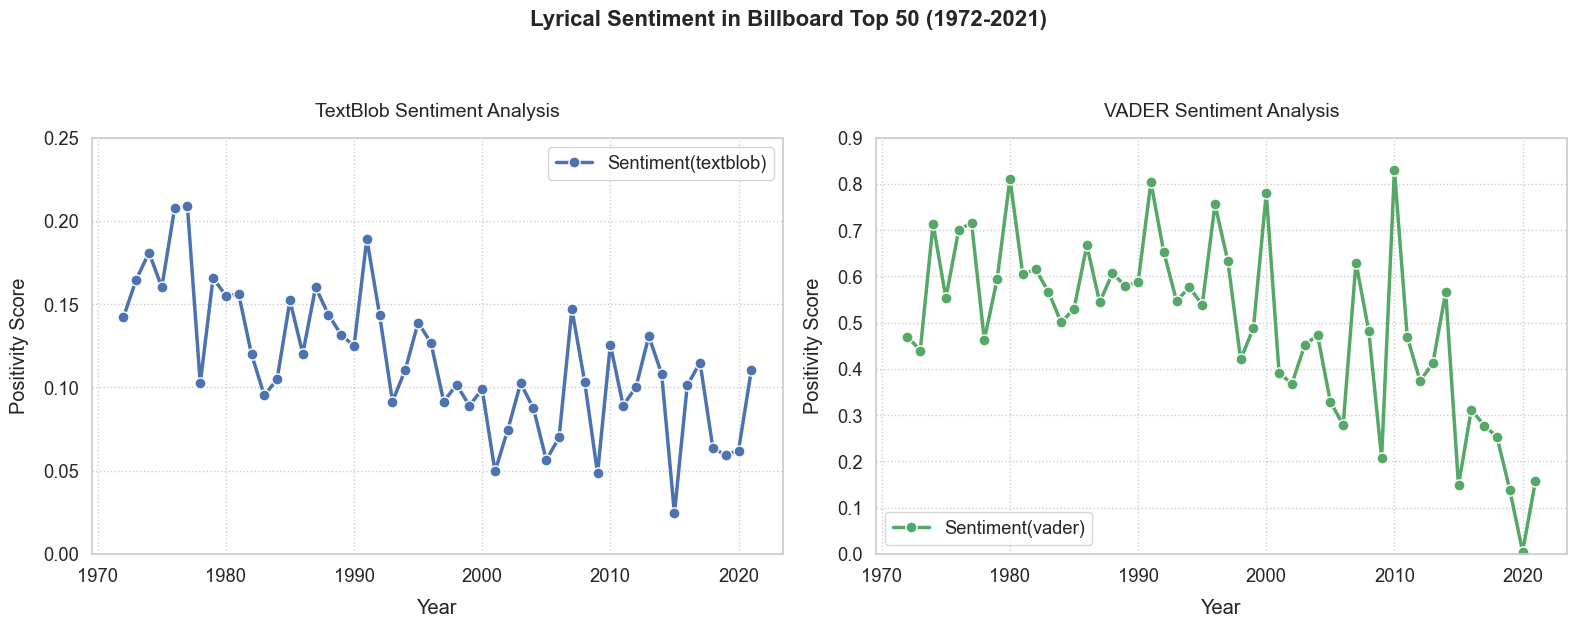

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
sns.set_style("whitegrid", {'grid.linestyle': ':'})  # Dotted grid for subtlety
plt.rcParams['font.family'] = 'sans-serif'  # Clean modern font

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
fig.suptitle('Lyrical Sentiment in Billboard Top 50 (1972-2021)', 
             y=1.05, fontsize=16, fontweight='bold')

# TextBlob Plot
ax1 = df_cleaned.groupby("Year")["Sentiment(textblob)"].mean().plot(
    ax=ax1,
    color='#4C72B0', 
    marker='o',
    markersize=8,
    linewidth=2.5,
    markeredgecolor='white',
    markeredgewidth=1
)
ax1.set_title("TextBlob Sentiment Analysis", pad=15, fontsize=14)
ax1.set_xlabel("Year", labelpad=10)
ax1.set_ylabel("Positivity Score", labelpad=10)
ax1.set_ylim(0, 0.25)

# VADER Plot
ax2 = df_cleaned.groupby("Year")["Sentiment(vader)"].mean().plot(
    ax=ax2,
    color='#55A868', 
    marker='o',
    markersize=8,
    linewidth=2.5,
    markeredgecolor='white',
    markeredgewidth=1
)
ax2.set_title("VADER Sentiment Analysis", pad=15, fontsize=14)
ax2.set_xlabel("Year", labelpad=10)
ax2.set_ylabel("Positivity Score", labelpad=10)
ax2.set_ylim(0, 0.9)


# Legend and layout
ax1.legend(frameon=True, facecolor='white')
ax2.legend(frameon=True, facecolor='white')
plt.tight_layout()
plt.savefig('sentiment_trends.png', dpi=300, bbox_inches='tight')  # For blog embedding
plt.show()

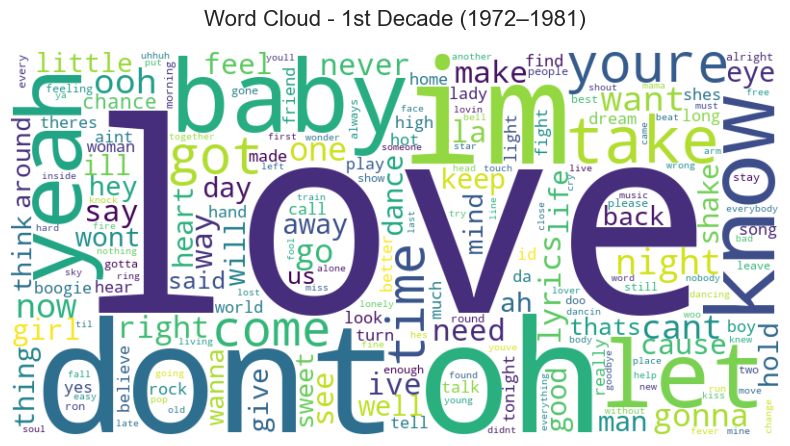

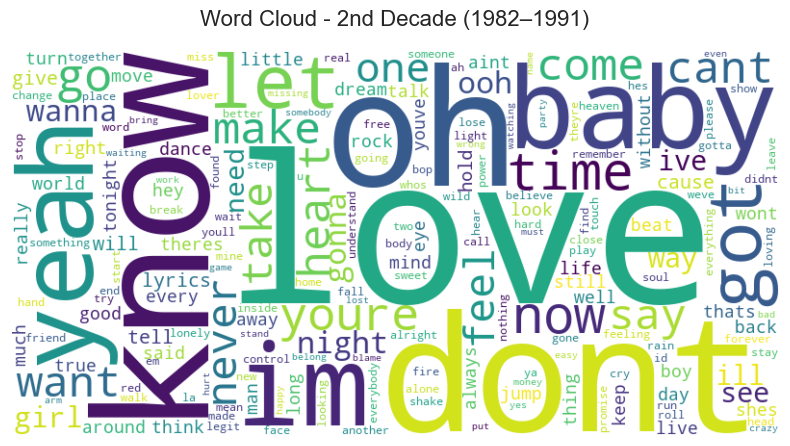

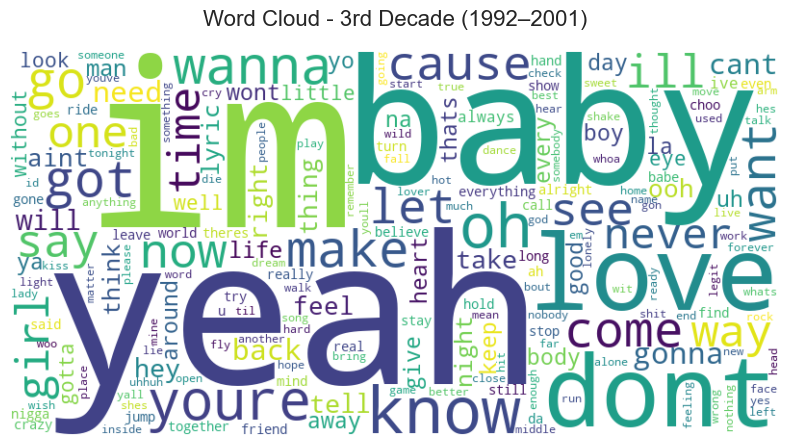

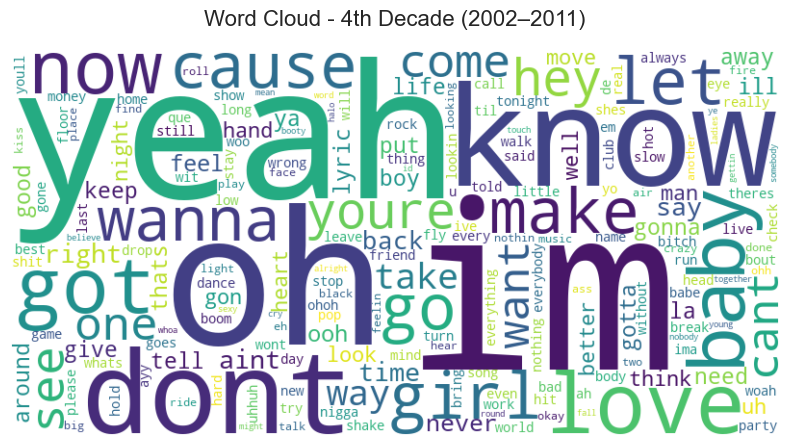

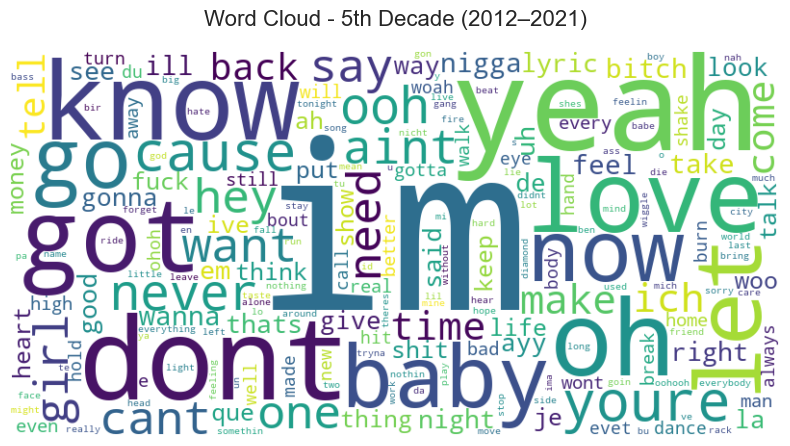

In [196]:
# Define your filler words
#common_filler_words = {"dont", "oh", "yeah", "im", "youre", "know", "got", "let", "time", "wanna"}
common_filler_words = {"xyz"}
# Clean text function
def clean_text(text):
    words = text.lower().split()
    words = [word for word in words if word not in common_filler_words]
    return ' '.join(words)

# Clean and combine lyrics by decade
first_decade = clean_text(" ".join(df[df['Year'].between(1972, 1982)]["Lyrics"].dropna()))
second_decade = clean_text(" ".join(df[df['Year'].between(1982, 1992)]["Lyrics"].dropna()))
third_decade = clean_text(" ".join(df[df['Year'].between(1992, 2002)]["Lyrics"].dropna()))
fourth_decade = clean_text(" ".join(df[df['Year'].between(2002, 2012)]["Lyrics"].dropna()))
fifth_decade = clean_text(" ".join(df[df['Year'].between(2012, 2021)]["Lyrics"].dropna()))

# Wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Plot function to avoid repeating code
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate all word clouds
plot_wordcloud(first_decade, "Word Cloud - 1st Decade (1972–1981)")
plot_wordcloud(second_decade, "Word Cloud - 2nd Decade (1982–1991)")
plot_wordcloud(third_decade, "Word Cloud - 3rd Decade (1992–2001)")
plot_wordcloud(fourth_decade, "Word Cloud - 4th Decade (2002–2011)")
plot_wordcloud(fifth_decade, "Word Cloud - 5th Decade (2012–2021)")

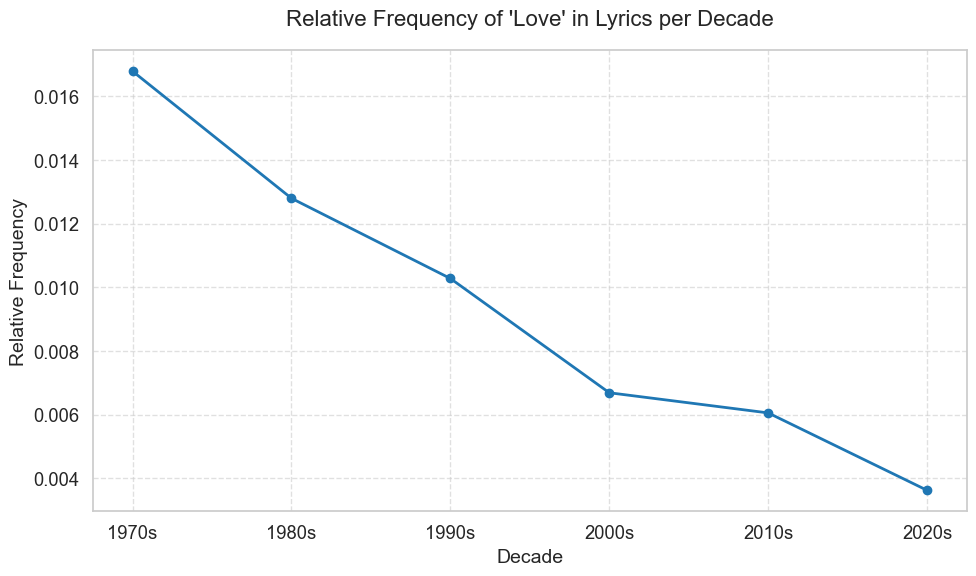

In [204]:
# Load your dataset
df = df_cleaned

# Drop rows with missing lyrics
df = df.dropna(subset=['Lyrics']).copy()


# Define a function to count total words and 'love' mentions
def count_words_and_love(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation, lowercase
    words = text.split()
    total_words = len(words)
    love_count = sum(1 for word in words if word == 'love')
    return total_words, love_count

# Apply the function
df[['Total_Words', 'Love_Count']] = df['Lyrics'].apply(lambda x: pd.Series(count_words_and_love(x)))

# Create a Decade column
df['Decade'] = (df['Year'] // 10) * 10

# Group by decade
decade_summary = df.groupby('Decade').sum()

# Calculate relative frequency
decade_summary['Love_Relative_Frequency'] = decade_summary['Love_Count'] / decade_summary['Total_Words']

# Plot
plt.figure(figsize=(10,6))
plt.plot(decade_summary.index, decade_summary['Love_Relative_Frequency'], marker='o', linewidth=2)
plt.title("Relative Frequency of 'Love' in Lyrics per Decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Relative Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(decade_summary.index, labels=[f"{int(d)}s" for d in decade_summary.index])
plt.tight_layout()
plt.show()


In [209]:
# Define the list of misogynistic words
misogynistic_words = [
    "pussy", "bitch", "bitches","hoe", "whore", "female", "booty", "gold diggers",
    "side chick", "thot", "bunny", "brick house", "good girl", "pipe her",
    "tits", "breasts", "vagina", "her body", "that body", "fuck her",
    "shake that", "good girls", "ass", "chick",  "ho", "baby girl",
    "pum pum", "slap her", "smack that","hoes","twerk","run a train", 
]

#daddy is said 235 times, sex 170, sexy 294

# Create a regex pattern to match whole words only (case-insensitive)
pattern_dict = {word: re.compile(rf'\b{re.escape(word)}\b', flags=re.IGNORECASE) for word in misogynistic_words}

# Count occurrences of each word across all lyrics, 
word_counts = {word: 0 for word in misogynistic_words}

for lyric in df_cleaned["Lyrics"].dropna():
    for word, pattern in pattern_dict.items():
        word_counts[word] += len(pattern.findall(lyric))

# Convert to DataFrame for display
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)

# Show results
print(word_counts_df)


              Count
bitch           648
ass             321
booty           278
ho              235
bitches         161
hoes            151
baby girl       130
chick            93
shake that       74
that body        72
pussy            66
good girl        40
twerk            37
good girls       34
smack that       34
pum pum          25
thot             15
bunny            10
whore            10
her body          8
breasts           6
female            5
pipe her          5
fuck her          4
tits              3
gold diggers      3
hoe               3
vagina            2
slap her          1
brick house       1
side chick        1
run a train       1


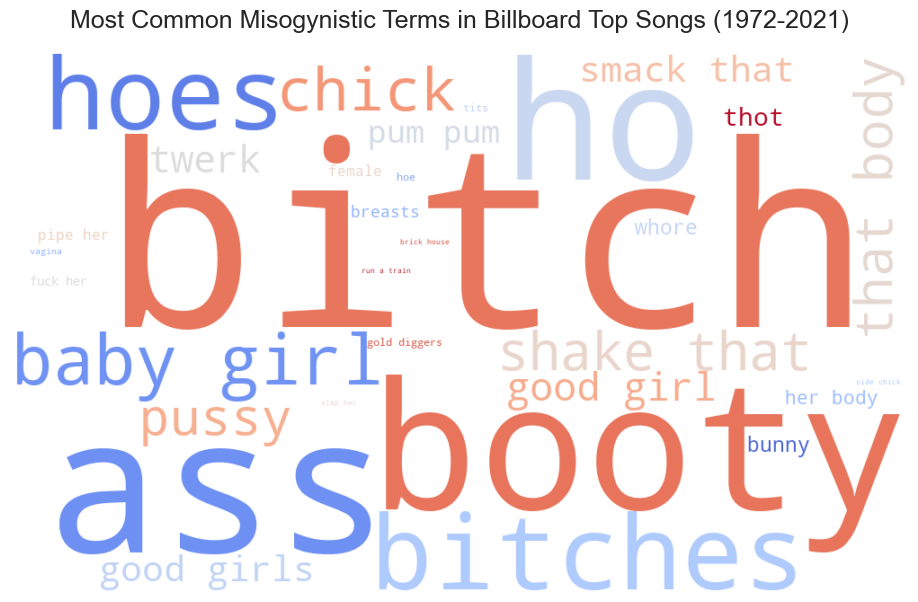

In [214]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

misogyny_word_counts = word_counts_df['Count'].to_dict()

# Generate the word cloud
wordcloud = WordCloud(
    width=1000, 
    height=600, 
    background_color='white', 
    colormap='coolwarm',  # nice blue-red gradient
    max_words=100
).generate_from_frequencies(misogyny_word_counts)

# Plot
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Misogynistic Terms in Billboard Top Songs (1972-2021)', fontsize=18)
plt.show()


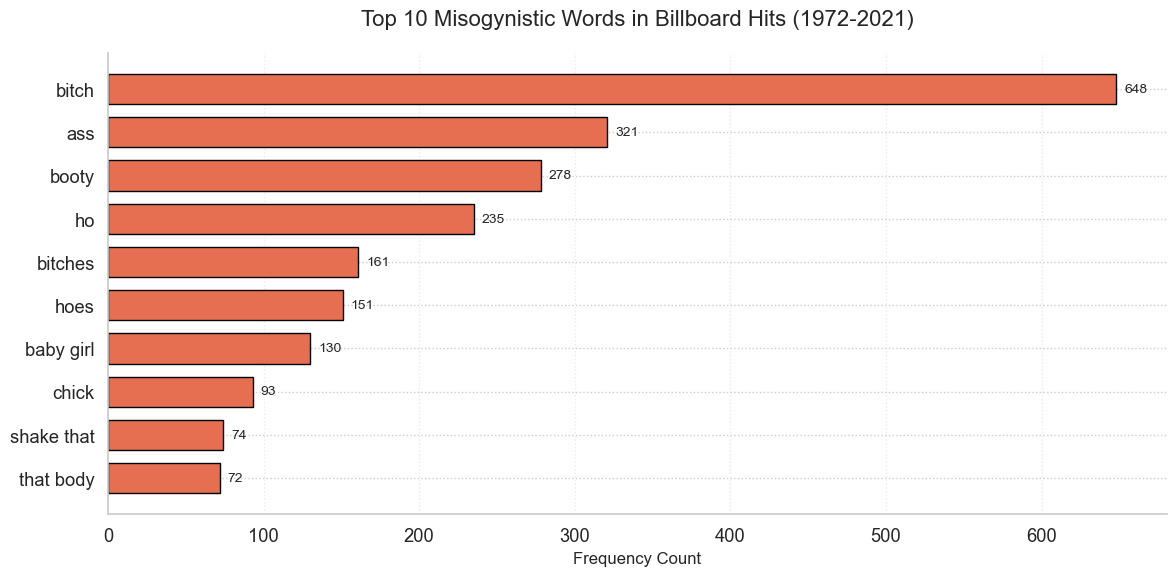

In [213]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming word_counts_df is already created as shown in your code:
# word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["Count"])

# Get top 10 (already sorted)
top10 = word_counts_df.head(10)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top10.index, top10['Count'],  # Use DataFrame index for labels
               color='#e76f51', height=0.7, edgecolor='black')

# Add styling
plt.xlabel('Frequency Count', fontsize=12)
plt.title('Top 10 Misogynistic Words in Billboard Hits (1972-2021)', 
         fontsize=16, pad=20)
plt.gca().invert_yaxis()  # Highest count at top
plt.grid(axis='x', linestyle=':', alpha=0.4)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, 
            f'{int(width)}', 
            va='center', ha='left', fontsize=10)

# Clean up spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [157]:
# Compile a regex pattern to match the words (case-insensitive)
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, misogynistic_words)) + r')\b', re.IGNORECASE)

# Count how many misogynistic terms appear in each lyric
df_cleaned["Misogynistic_Word_Count"] = df_cleaned["Lyrics"].apply(lambda x: len(pattern.findall(x)) if isinstance(x, str) else 0)

# Flag whether the song is misogynistic (any count > 0)
df_cleaned["Is_Misogynistic"] = df_cleaned["Misogynistic_Word_Count"] > 0

# 📊 Group by year and summarize
summary = df_cleaned.groupby("Year").agg(
    Songs_Checked=("Lyrics", "count"),
    Misogynistic_Songs=("Is_Misogynistic", "sum"),
    Total_Misogynistic_Words=("Misogynistic_Word_Count", "sum")
).reset_index()

# Add % of misogynistic songs
summary["Percentage_Misogynistic_Songs"] = (
    summary["Misogynistic_Songs"] / summary["Songs_Checked"] * 100
)

# Preview
summary.head()

# Optional: Save for plotting later
summary.to_csv("misogyny_by_year.csv", index=False)

summary.head(50)

,Year,Songs_Checked,Misogynistic_Songs,Total_Misogynistic_Words,Percentage_Misogynistic_Songs
0,1972,47,0,0,0.000000
1,1973,49,1,1,2.040816
2,1974,48,0,0,0.000000
3,1975,48,1,8,2.083333
4,1976,44,2,21,4.545455
5,1977,48,2,8,4.166667
6,1978,46,1,1,2.173913
7,1979,49,1,1,2.040816
8,1980,44,0,0,0.000000
9,1981,48,1,2,2.083333


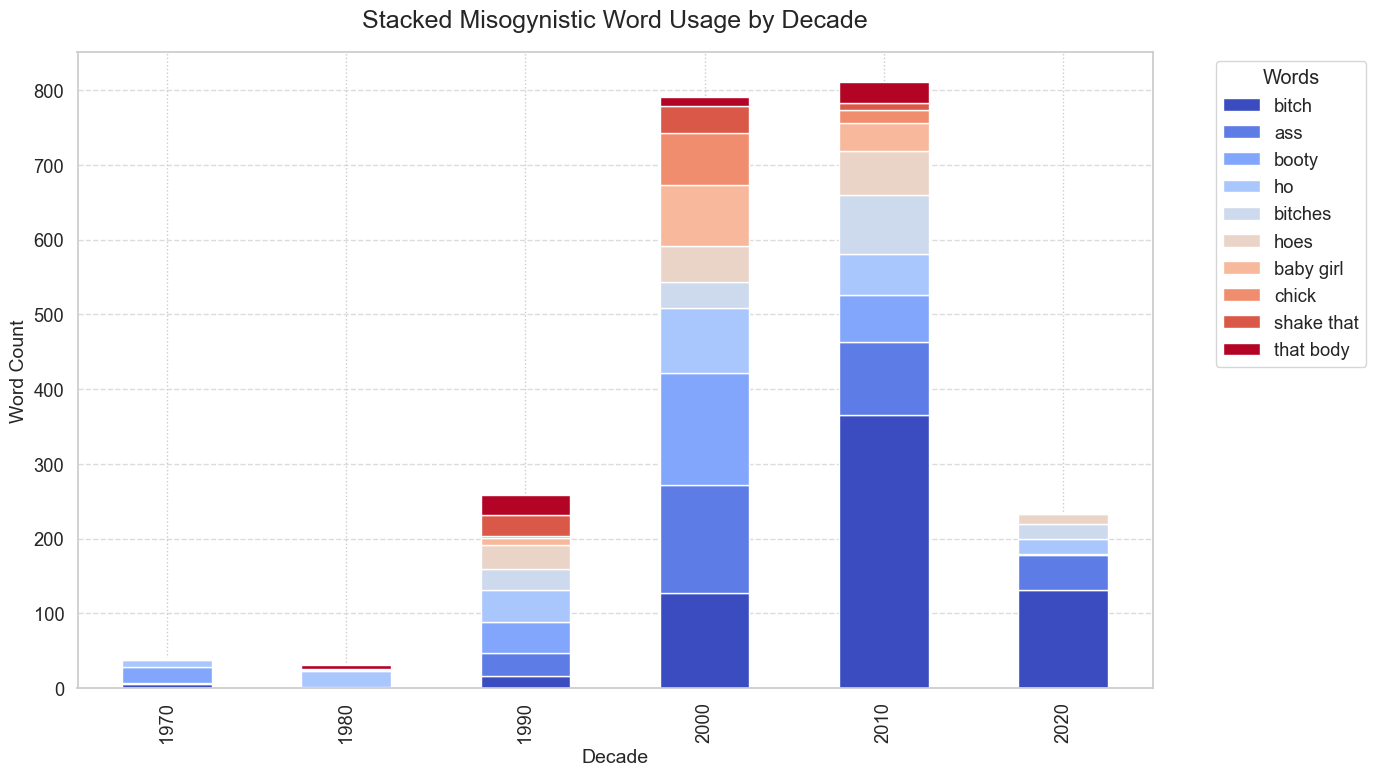

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Assuming you have your main DataFrame as df_cleaned
# and your misogynistic words list ready

# Step 1: Define misogynistic words
misogynistic_words = [
    "pussy", "bitch", "bitches", "hoe", "whore", "female", "booty", "gold diggers",
    "side chick", "thot", "bunny", "brick house", "good girl", "pipe her",
    "tits", "breasts", "vagina", "her body", "that body", "fuck her",
    "shake that", "good girls", "ass", "chick", "ho", "baby girl",
    "pum pum", "slap her", "smack that", "hoes", "twerk", "run a train"
]

# Step 2: Create a clean lyrics column (optional, in case not already clean)
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    return text.lower()

df_cleaned['Lyrics_Clean'] = df_cleaned['Lyrics'].dropna().apply(clean_lyrics)

# Step 3: Create a decade column
df_cleaned['Decade'] = (df_cleaned['Year'] // 10) * 10

# Step 4: Count misogynistic words for each decade
decade_counts = {}

for decade, group in df_cleaned.groupby('Decade'):
    lyrics = " ".join(group['Lyrics_Clean'].dropna())
    word_freq = {word: len(re.findall(r'\b' + re.escape(word) + r'\b', lyrics)) for word in misogynistic_words}
    decade_counts[decade] = word_freq

# Step 5: Convert to DataFrame
decade_word_df = pd.DataFrame(decade_counts).fillna(0).astype(int)

# Step 6: Select top N words overall to make it clean
top_words = word_counts_df.head(10).index.tolist()  # Top 10 misogynistic words
decade_word_df = decade_word_df.loc[top_words]

# Step 7: Plot the stacked bar chart
decade_word_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='coolwarm'
)

plt.title('Stacked Misogynistic Word Usage by Decade', fontsize=18)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Word Count', fontsize=14)
plt.legend(title='Words', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [159]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


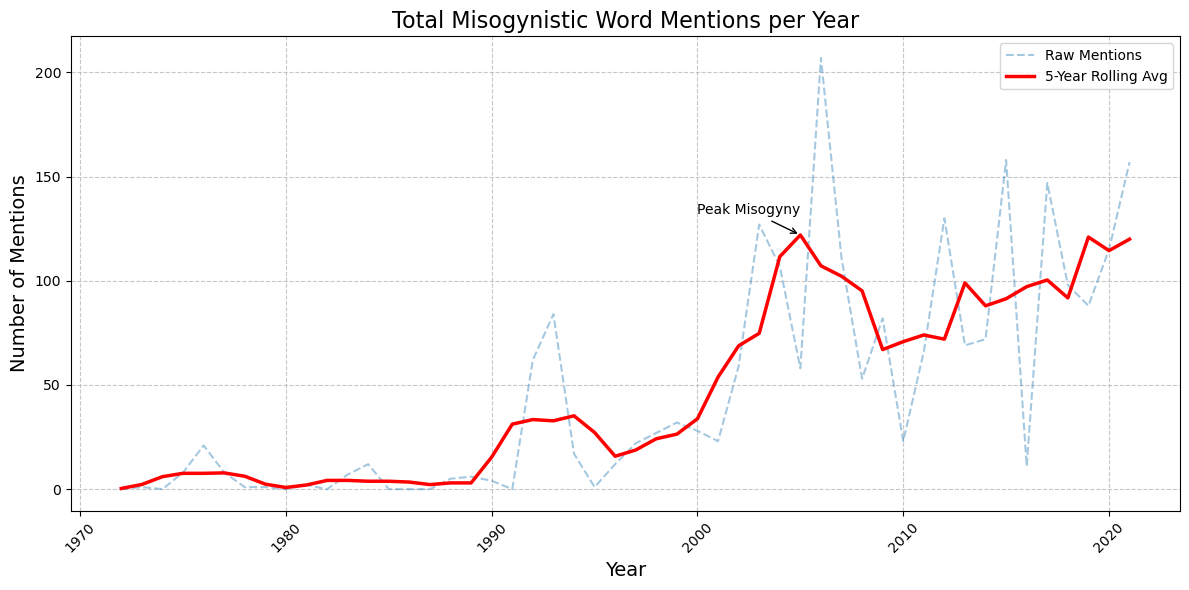

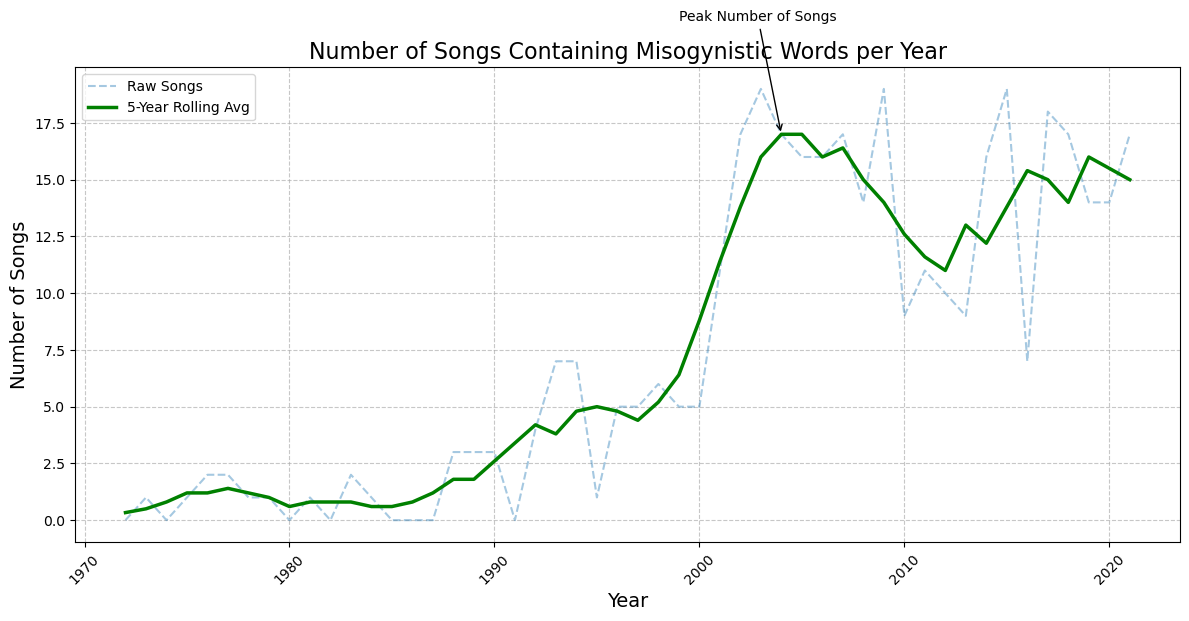

In [160]:
from wordcloud import WordCloud
# Precompile regex patterns
word_patterns = [re.compile(r'\b' + re.escape(word) + r'\b', re.IGNORECASE) for word in misogynistic_words]

# Analyze each song
records = []
for song in all_lyrics:
    lyrics = song.get('Lyrics', '') or ""
    year = song.get('Year', None)
    
    if lyrics and isinstance(lyrics, str):
        total_mentions = sum(len(pattern.findall(lyrics)) for pattern in word_patterns)
        contains_misogyny = int(total_mentions > 0)
    else:
        total_mentions = 0
        contains_misogyny = 0
    
    records.append({
        "Year": year,
        "Lyrics": lyrics,
        "TotalMentions": total_mentions,
        "ContainsMisogyny": contains_misogyny
    })

# Create DataFrame
df = pd.DataFrame(records)

# Group by Year
yearly_summary = df.groupby("Year").agg({
    "TotalMentions": "sum",
    "ContainsMisogyny": "sum"
}).reset_index()

# Rolling averages (5-year window)
yearly_summary["MentionsRolling"] = yearly_summary["TotalMentions"].rolling(window=5, center=True, min_periods=1).mean()
yearly_summary["SongsRolling"] = yearly_summary["ContainsMisogyny"].rolling(window=5, center=True, min_periods=1).mean()

# --- Plot Total Misogynistic Word Mentions per Year ---
plt.figure(figsize=(12, 6))
plt.plot(yearly_summary["Year"], yearly_summary["TotalMentions"], alpha=0.4, linestyle='--', label="Raw Mentions")
plt.plot(yearly_summary["Year"], yearly_summary["MentionsRolling"], color='red', linewidth=2.5, label="5-Year Rolling Avg")
plt.title("Total Misogynistic Word Mentions per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Mentions", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate peak
peak_year = yearly_summary.loc[yearly_summary["MentionsRolling"].idxmax(), "Year"]
peak_value = yearly_summary["MentionsRolling"].max()
plt.annotate('Peak Misogyny', xy=(peak_year, peak_value), xytext=(peak_year-5, peak_value+10),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.show()

# --- Plot Number of Songs Containing Misogynistic Words per Year ---
plt.figure(figsize=(12, 6))
plt.plot(yearly_summary["Year"], yearly_summary["ContainsMisogyny"], alpha=0.4, linestyle='--', label="Raw Songs")
plt.plot(yearly_summary["Year"], yearly_summary["SongsRolling"], color='green', linewidth=2.5, label="5-Year Rolling Avg")
plt.title("Number of Songs Containing Misogynistic Words per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Songs", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate peak
peak_year_songs = yearly_summary.loc[yearly_summary["SongsRolling"].idxmax(), "Year"]
peak_value_songs = yearly_summary["SongsRolling"].max()
plt.annotate('Peak Number of Songs', xy=(peak_year_songs, peak_value_songs), xytext=(peak_year_songs-5, peak_value_songs+5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.show()




#word cloud
#stacked bar charts per year for top 10 most used words 
heatmap for correlation with gnedered type of artist

#Scatter Plot: Misogyny vs. Song Popularity
X-axis: Misogyny score

Y-axis: Billboard ranking (1–50)

Insight: Do more offensive songs chart higher?


#would love to add where are the artists from e.g. prevalence by country, would love to look at misandry


#actual proportion of male and female artists over the years


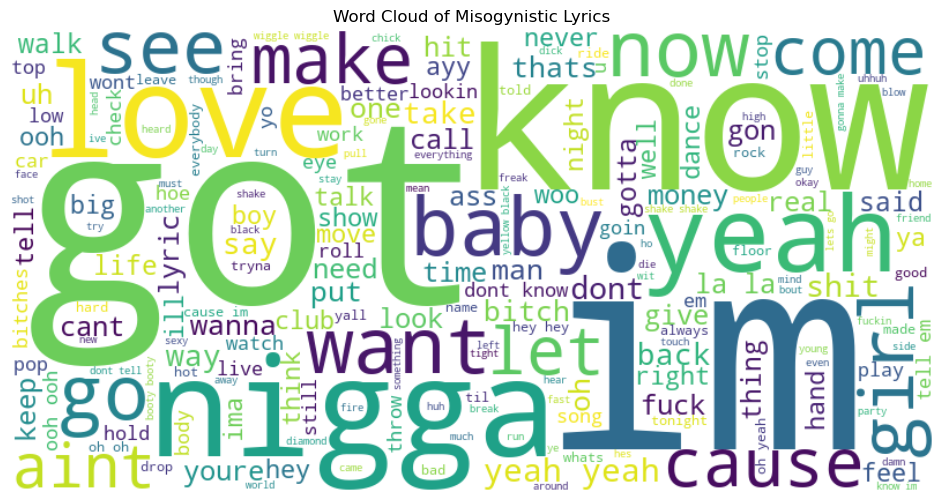

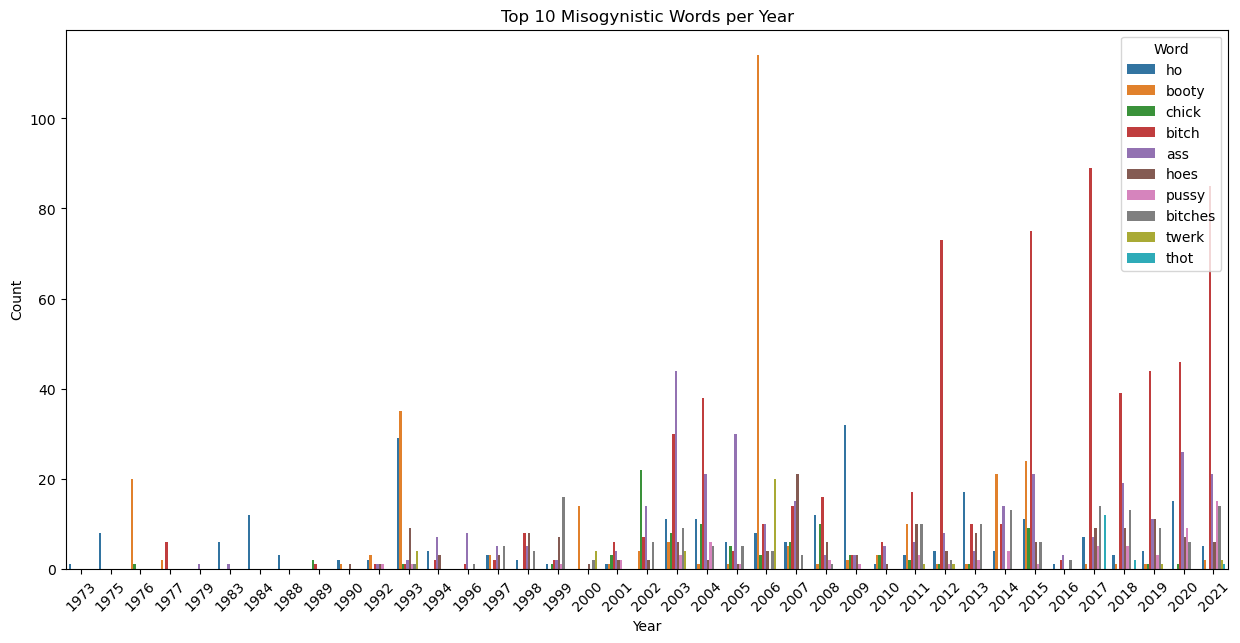

KeyError: 'Gender'

In [162]:
import seaborn as sns
from collections import Counter

# --- Load the data ---
with open('all_lyrics_cleaned.json', 'r', encoding='utf-8') as f:
    songs = json.load(f)

# --- Convert songs into DataFrame ---
df = pd.DataFrame(songs)

# --- Clean lyrics ---
def clean_text(text):
    if not text or text == 'None':
        return ""
    return re.sub(r'[^\w\s]', '', text.lower())

df['Cleaned_Lyrics'] = df['Lyrics'].apply(clean_text)

# --- Count misogynistic words ---
def count_misogyny(text):
    words = text.split()
    word_counter = Counter(words)
    count = sum(word_counter[word] for word in misogynistic_words if word in word_counter)
    return count

df['Misogyny_Count'] = df['Cleaned_Lyrics'].apply(count_misogyny)

# --- Calculate normalized misogyny score (optional) ---
df['Misogyny_Score'] = df['Misogyny_Count'] / df['Cleaned_Lyrics'].str.split().apply(lambda x: len(x) if x else 1)

# --- Filter songs that were ranked (optional, if you have ranking) ---
# If you have a "Ranking" column (1–50), we can filter based on that
# df = df[df['Ranking'] <= 50]

# -----------------------
# 1. Word Cloud for Misogynistic Songs
# -----------------------
misogynistic_lyrics = ' '.join(df[df['Misogyny_Count'] > 0]['Cleaned_Lyrics'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(misogynistic_lyrics)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Misogynistic Lyrics')
plt.show()

# -----------------------
# 2. Stacked Bar Chart - Top 10 Most Used Misogynistic Words by Year
# -----------------------
# Expand into a big list of words per song
def find_misogynistic_words(text):
    words = text.split()
    return [word for word in words if word in misogynistic_words]

df['Found_Misogynistic_Words'] = df['Cleaned_Lyrics'].apply(find_misogynistic_words)

# Expand into rows
exploded = df.explode('Found_Misogynistic_Words')
top_words_year = exploded.groupby(['Year', 'Found_Misogynistic_Words']).size().reset_index(name='Count')

# Pick top 10 words overall
top_words = top_words_year.groupby('Found_Misogynistic_Words')['Count'].sum().nlargest(10).index.tolist()
top_words_year = top_words_year[top_words_year['Found_Misogynistic_Words'].isin(top_words)]

plt.figure(figsize=(15, 7))
sns.barplot(data=top_words_year, x='Year', y='Count', hue='Found_Misogynistic_Words')
plt.title('Top 10 Misogynistic Words per Year')
plt.xticks(rotation=45)
plt.legend(title='Word')
plt.show()

# -----------------------
# 3. Heatmap - Misogyny Correlation with Gender Type
# -----------------------
# Encode gender into numeric
gender_map = {'Male': 0, 'Female': 1, 'Mixed group': 2, 'Male group': 3, 'Female group': 4, 'Unknown': -1}
df['Gender_Code'] = df['Gender'].map(gender_map)

plt.figure(figsize=(8, 6))
corr = df[['Misogyny_Count', 'Gender_Code']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Misogyny Count and Artist Gender')
plt.show()

# -----------------------
# 4. Scatter Plot - Misogyny Score vs Billboard Ranking
# -----------------------
if 'Ranking' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Misogyny_Score', y='Ranking', hue='Gender')
    plt.title('Misogyny Score vs Billboard Ranking')
    plt.xlabel('Misogyny Score')
    plt.ylabel('Billboard Ranking (1 is best)')
    plt.gca().invert_yaxis()  # Because rank 1 is better than 50
    plt.show()
